## Let's plot the gordon network atlas

#### # networks that we care about
#### dim 1: 10, 1, 13, 4
#### dim 3: 3, 1, 11, 4
#### networks = [10, 1, 13, 4]
#### network_map = {10: "CinguloOperc", 1: "Default", 13: "DorsalAttn", 4: "Visual"}

#### '''networks = [3, 1, 11, 4]
#### network_map = {3: "SensoriMouth", 1: "Default", 11: "VentralAttn", 4: "Visual"}'''

<!-- # Define network pairs for each map
network_pairs = [
    (10, 1),  # CinguloOperc + Default
    (1, 11),  # Default + VentralAttn
    (1, 1),  # Default + Default
    (1, 4),  # Default + Visual
    (4, 4),  # Visual + Visual
    (1, 3),  # Default + SensoriMouth
    (11, 4)  # VentralAttn + Visual
]

# Labels
network_map = {
    10: "CinguloOperc",
    1: "Default",
    11: "VentralAttn",
    4: "Visual",
    3: "SensoriMouth",
} -->


In [56]:
# importing the tools we'll use throughout the rest of the script
# sys is system tools, should already be installed
import sys
import json

# pandas is a dataframe-managing library and it's the absolute coolest
import pandas as pd

# numpy is short for "numerical python" and it does math
import numpy as np

# seaborn is a plotting library named after a character from West Wing
# it's kind of like python's ggplot
import seaborn as sns

# nibabel handles nifti images
import nibabel as nib

# os is more system tools, should also already be installed
# we're importing tools for verifying and manipulating file paths/directories
from os.path import join, exists, isdir
from os import makedirs

# nilearn makes the best brain plots
# and their documentation/examples are so, so handy
# https://nilearn.github.io/stable/auto_examples/01_plotting/index.html
from nilearn import plotting, surface, datasets

# matplotlib is the backbone of most python plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# gridspec helps us put lots of panels on one figure
from matplotlib.gridspec import GridSpec


%matplotlib inline

In [49]:
fig_dir = "./derivatives/none-reduced/figures"
nii_dir = "./derivatives/none-reduced/nifti"

# Create directory if it doesn't exist
if not exists(fig_dir):
    makedirs(fig_dir)

if not exists(nii_dir):
    makedirs(nii_dir)

In [57]:
CMAP = "Spectral_r"

def plot_surf(nii_img_thr, mask_contours=None, vmax=8, cmap=CMAP):
    map_lh, map_rh = transforms.mni152_to_fslr(nii_img_thr, fslr_density="32k")
    map_lh, map_rh = _zero_medial_wall(
        map_lh,
        map_rh,
        space="fsLR",
        density="32k",
    )
    # midthickness

    surfaces = fetch_fslr(density="32k")
    lh, rh = surfaces["inflated"]
    sulc_lh, sulc_rh = surfaces["sulc"]

    p = Plot(surf_lh=lh, surf_rh=rh, layout="grid")
    p.add_layer({"left": sulc_lh, "right": sulc_rh}, cmap="binary_r", cbar=False)
    p.add_layer(
        {"left": map_lh, "right": map_rh},
        cmap=cmap,
        cbar=False,
        color_range=(-vmax, vmax),
    )
    if mask_contours:
        mask_lh, mask_rh = transforms.mni152_to_fslr(mask_contours, fslr_density="32k")
        mask_lh, mask_rh = _zero_medial_wall(
            mask_lh,
            mask_rh,
            space="fsLR",
            density="32k",
        )
        mask_arr_lh = mask_lh.agg_data()
        mask_arr_rh = mask_rh.agg_data()
        countours_lh = np.zeros_like(mask_arr_lh)
        countours_lh[mask_arr_lh != 0] = 1
        countours_rh = np.zeros_like(mask_arr_rh)
        countours_rh[mask_arr_rh != 0] = 1

        colors = [(0, 0, 0, 0)]
        contour_cmap = ListedColormap(colors, "regions", N=1)
        line_cmap = ListedColormap(["black"], "regions", N=1)
        p.add_layer(
            {"left": countours_lh, "right": countours_rh},
            cmap=line_cmap,
            as_outline=True,
            cbar=False,
        )
        p.add_layer(
            {"left": countours_lh, "right": countours_rh},
            cmap=contour_cmap,
            cbar=False,
        )

    return p.build()

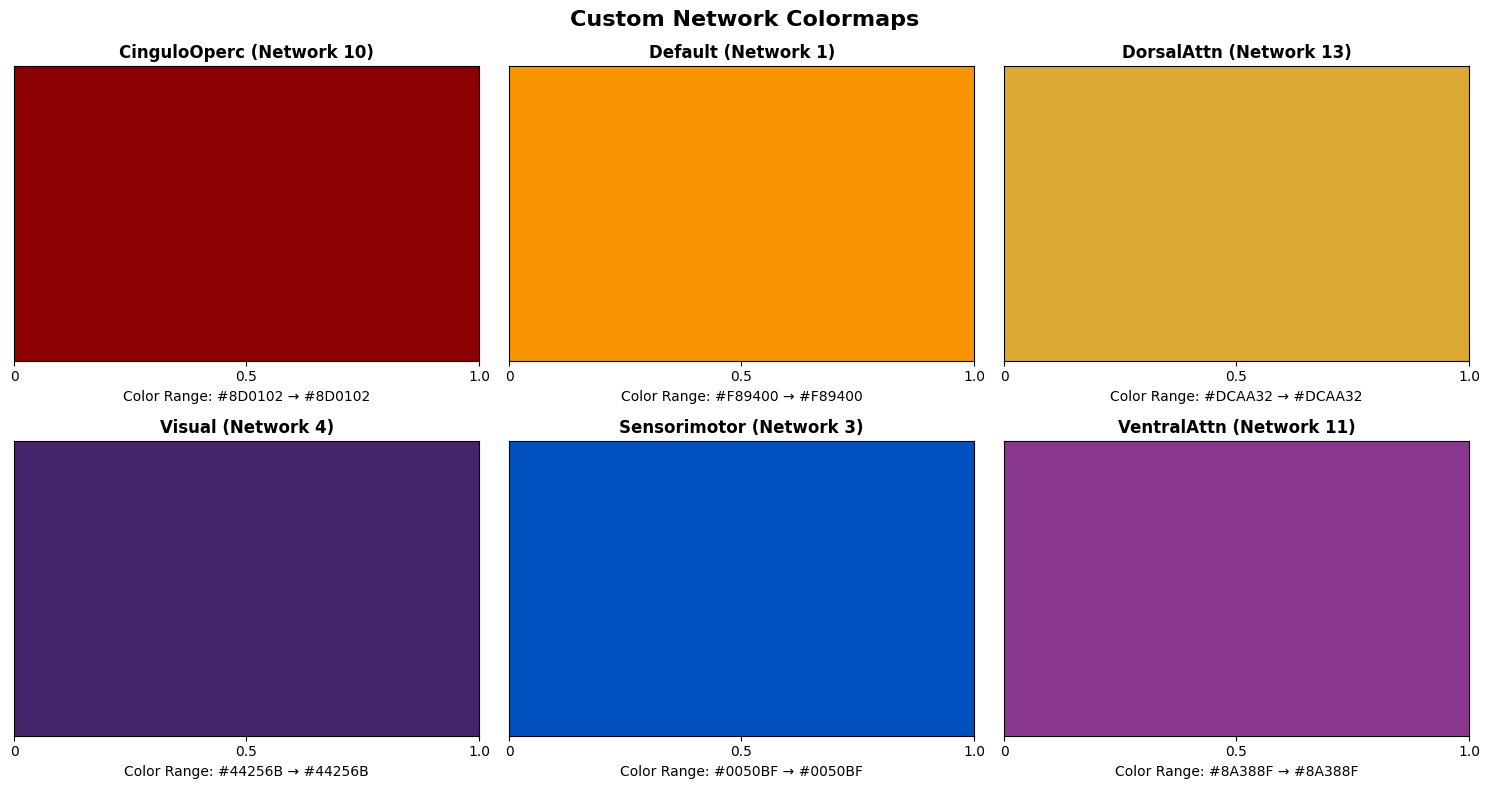

In [67]:
# Define the number of colors in the colormap
num_colors = 1000

# Define custom colormaps for each network
# CinguloOperc - Dark Blue gradient
colors10 = ["#8D0102", "#8D0102"]
cmap10 = LinearSegmentedColormap.from_list("CinguloOperc", colors10, N=num_colors)

# Default - Dark Blue gradient
colors1 = ["#F89400", "#F89400"]
cmap1 = LinearSegmentedColormap.from_list("Default", colors1, N=num_colors)

# DorsalAttn - Orange to Red gradient
colors13 = ["#DCAA32", "#DCAA32"]
cmap13 = LinearSegmentedColormap.from_list("DorsalAttn", colors13, N=num_colors)

# Visual - Orange to Yellow gradient
colors4 = ["#44256B", "#44256B"]
cmap4 = LinearSegmentedColormap.from_list("Visual", colors4, N=num_colors)

# Sensorimotor - Orange to Red gradient
colors3 = ["#0050BF", "#0050BF"]
cmap3 = LinearSegmentedColormap.from_list("SensoriMouth", colors3, N=num_colors)

# VentralAttn - Light Blue to Green gradient  
colors11 = ["#8A388F", "#8A388F"]
cmap11 = LinearSegmentedColormap.from_list("VentralAttn", colors11, N=num_colors)

# Display all custom colormaps
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Custom Network Colormaps", fontsize=16, fontweight='bold')

# Plot each colormap with network-specific information
cmaps = [cmap10, cmap1, cmap13, cmap4, cmap3, cmap11]
titles = ["CinguloOperc (Network 10)", "Default (Network 1)", 
          "DorsalAttn (Network 13)", "Visual (Network 4)",
          "Sensorimotor (Network 3)", "VentralAttn (Network 11)"]
colors_info = [colors10, colors1, colors13, colors4, colors3, colors11]

for i, (cmap, title, color_range) in enumerate(zip(cmaps, titles, colors_info)):
    row, col = i // 3, i % 3
    ax = axes[row, col]
    
    # Create colorbar
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.set_xlim(0, 255)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel(f'Color Range: {color_range[0]} → {color_range[1]}')
    ax.set_xticks([0, 127, 255])
    ax.set_xticklabels(['0', '0.5', '1.0'])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [68]:
# fetch once
surf = datasets.fetch_surf_fsaverage()

# load your full Gordon atlas
img = nib.load("./gordon_networks_222.nii")
data = img.get_fdata()
affine = img.affine
hdr = img.header

# networks that we care about
# dim 1: 10, 1, 13, 4
# dim 3: 3, 1, 11, 4
networks = [10, 1, 13, 4, 3, 11]
network_map = {10: "CinguloOperc", 1: "Default", 13: "DorsalAttn", 4: "Visual", 3:"Sensorimotor", 11:"VentralAttn"}

# Define colors for each network
network_colors = {
    10: cmap10,    # CinguloOperc
    1: cmap1,     # Default 
    13: cmap13,    # DorsalAttn 
    4: cmap4,     # Visual 
    3: cmap3, # SensoriMouth 
    11: cmap11  # VentralAttn
}


In [69]:
# Save each network as a binary NIfTI ROI
for net in networks:
    network_name = network_map[net]
    output_path = join(nii_dir, f"{network_name}_ROI.nii.gz")
    
    # Check if file already exists
    if exists(output_path):
        print(f"✓ {network_name} ROI already exists at {output_path}")
        continue
    
    # Create binary mask: 1 where data==net, 0 elsewhere
    mask_vol = (data == net).astype(np.uint8)
    mask_img = nib.Nifti1Image(mask_vol, affine, hdr)
    
    # Save NIfTI file
    nib.save(mask_img, output_path)
    print(f"✓ Saved {network_name} ROI to {output_path}")

✓ CinguloOperc ROI already exists at ./derivatives/none-reduced/nifti/CinguloOperc_ROI.nii.gz
✓ Default ROI already exists at ./derivatives/none-reduced/nifti/Default_ROI.nii.gz
✓ DorsalAttn ROI already exists at ./derivatives/none-reduced/nifti/DorsalAttn_ROI.nii.gz
✓ Visual ROI already exists at ./derivatives/none-reduced/nifti/Visual_ROI.nii.gz
✓ Sensorimotor ROI already exists at ./derivatives/none-reduced/nifti/Sensorimotor_ROI.nii.gz
✓ VentralAttn ROI already exists at ./derivatives/none-reduced/nifti/VentralAttn_ROI.nii.gz


✓ Saved CinguloOperc surface plot to ./derivatives/none-reduced/figures/CinguloOperc_surface_plot.png


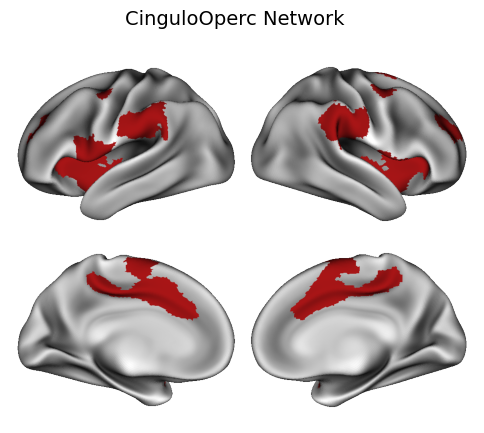

✓ Saved Default surface plot to ./derivatives/none-reduced/figures/Default_surface_plot.png


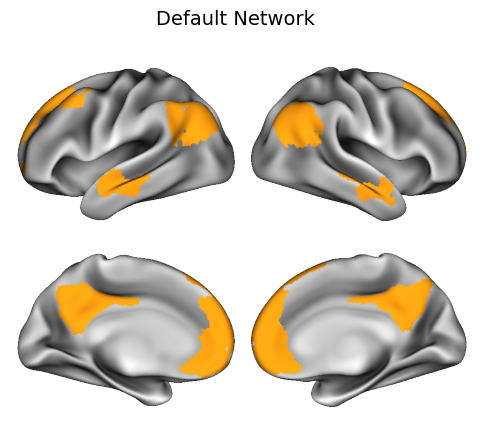

✓ Saved DorsalAttn surface plot to ./derivatives/none-reduced/figures/DorsalAttn_surface_plot.png


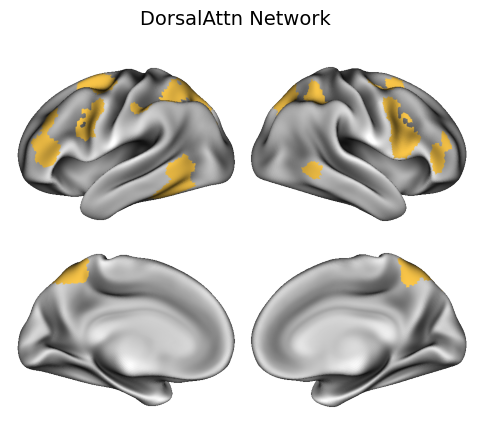

✓ Saved Visual surface plot to ./derivatives/none-reduced/figures/Visual_surface_plot.png


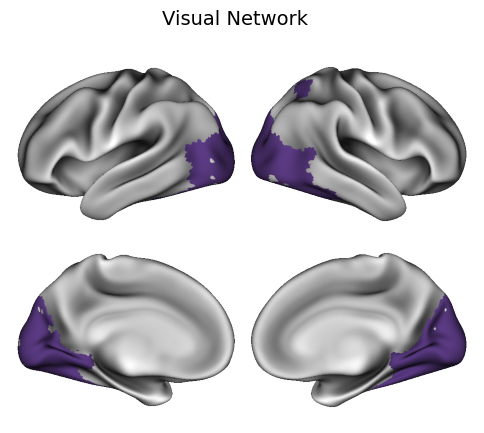

✓ Saved Sensorimotor surface plot to ./derivatives/none-reduced/figures/Sensorimotor_surface_plot.png


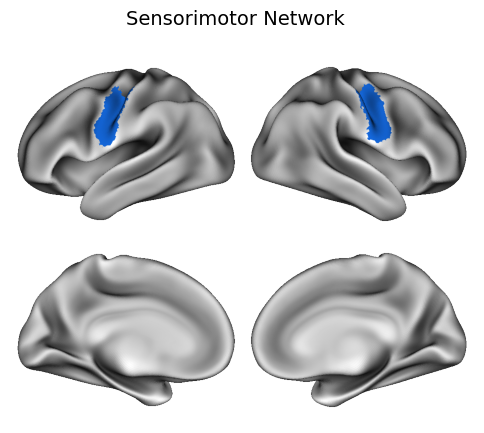

✓ Saved VentralAttn surface plot to ./derivatives/none-reduced/figures/VentralAttn_surface_plot.png


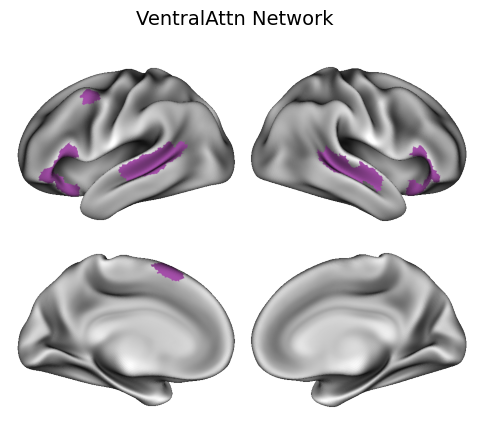

In [71]:
# Load and plot each binary mask using plot_surf function
for net in networks:
    network_name = network_map[net]
    roi_path = join(nii_dir, f"{network_name}_ROI.nii.gz")

    # Load the saved ROI
    roi_img = nib.load(roi_path)

    # Get the color for this network
    network_cmap = network_colors[net]

    # Plot using plot_surf function with FSL surfaces
    fig = plot_surf(
        nii_img_thr=roi_img,
        vmax=1,  # Binary mask has values 0 and 1
        cmap=network_cmap
    )
    # Add title to the plot
    fig.suptitle(f"{network_name} Network", y=0.95, fontsize=14)
    
    # Save as high-resolution PNG
    output_filename = f"{network_name}_surface_plot.png"
    output_path = join(fig_dir, output_filename)
    fig.savefig(output_path, dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    print(f"✓ Saved {network_name} surface plot to {output_path}")
    
    plt.show()

## Plotting the bootstrap scores on one brain

In [ ]:
rsi_bootdf = pd.read_csv("./derivatives/none-reduced/rni-brain_P-components.csv")
sociocult_bootdf = pd.read_csv("./derivatives/none-reduced/rni-sociocult_Q-components.csv")
variable_df = pd.read_csv("./variable_to_nifti_mapping.csv")

print(rsi_bootdf)

                  Unnamed: 0        V1        V2        V3        V4  \
0   rsfmri_c_ngd_cgc_ngd_cgc  0.166900 -0.031414  0.163430  0.105299   
1    rsfmri_c_ngd_cgc_ngd_ca -0.053671  0.157942  0.109458  0.070879   
2    rsfmri_c_ngd_cgc_ngd_dt -0.224370 -0.259679 -0.101223 -0.004705   
3   rsfmri_c_ngd_cgc_ngd_dla  0.128754  0.081618  0.110008 -0.109035   
4    rsfmri_c_ngd_cgc_ngd_fo -0.173704  0.038306 -0.124875  0.135296   
..                       ...       ...       ...       ...       ...   
61  rsfmri_c_ngd_smm_ngd_vta  0.090719 -0.104000 -0.212907 -0.040524   
62   rsfmri_c_ngd_smm_ngd_vs  0.043918  0.055418  0.238151  0.021985   
63  rsfmri_c_ngd_vta_ngd_vta -0.022812 -0.141838  0.227015 -0.097780   
64   rsfmri_c_ngd_vta_ngd_vs -0.137745 -0.013702 -0.327291 -0.039543   
65    rsfmri_c_ngd_vs_ngd_vs  0.260799 -0.068276  0.066909  0.030154   

          V5        V6        V7        V8        V9  ...       V16       V17  \
0  -0.043089 -0.139590 -0.026246 -0.075051  0.075285  

In [ ]:
# Rename the first column in rsi_bootdf to match variable_df column name (
rsi_bootdf = rsi_bootdf.rename(columns={rsi_bootdf.columns[0]: "Variable"})
variable_df = variable_df.rename(columns={variable_df.columns[0]: "Variable"})

# Keep only the 'Variable' and 'atlas_value' columns
rsi_bootdf = rsi_bootdf[["Variable", "Dimension 1"]]
variable_df = variable_df[["Variable", "atlas_value"]]

# Merge rsi_bootdf with variable_df on 'Variable'
merged_df = pd.merge(rsi_bootdf, variable_df, on="Variable", how="left")

print(merged_df.head())

                   Variable  Dimension 1  atlas_value
0  rsfmri_c_ngd_cgc_ngd_cgc     2.031047         10.0
1   rsfmri_c_ngd_cgc_ngd_ca    -0.729915         10.0
2   rsfmri_c_ngd_cgc_ngd_dt    -3.130818         10.0
3  rsfmri_c_ngd_cgc_ngd_dla     1.734342         10.0
4   rsfmri_c_ngd_cgc_ngd_fo    -2.296964         10.0


sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_40491/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


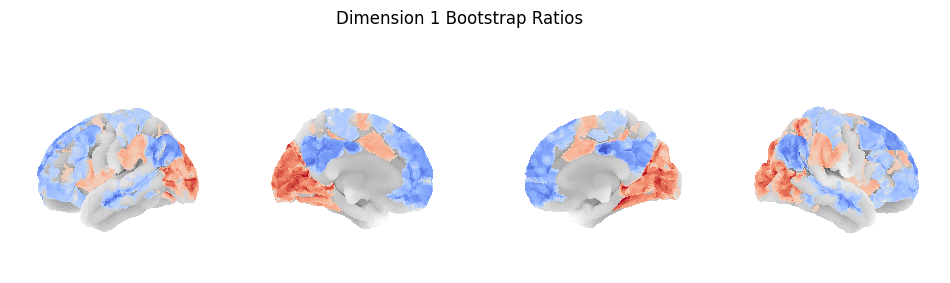

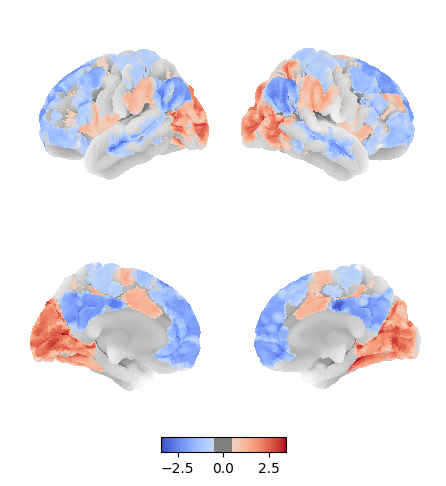

In [ ]:

# Load fsaverage surface
surf = datasets.fetch_surf_fsaverage()

# Load Gordon atlas
gordon_img = nib.load("./gordon_networks_222.nii")
gordon_data = gordon_img.get_fdata()
affine = gordon_img.affine
hdr = gordon_img.header

# Assume merged_df is already loaded and has 'atlas_value' and 'V1' columns

# Create volume to hold V1 values
v1_volume = np.zeros_like(gordon_data)

# Populate volume: set voxel value = V1 score for that atlas_value
for _, row in merged_df.iterrows():
    atlas_val = row["atlas_value"]
    v1_val = row["Dimension 1"]
    if not np.isnan(atlas_val):
        v1_volume[gordon_data == atlas_val] = v1_val

# Convert to NIfTI image
v1_img = nib.Nifti1Image(v1_volume, affine, hdr)

# Define colormap and max value
from matplotlib import cm

cmap = "coolwarm"
vmax = np.abs(merged_df["Dimension 1"]).max()

# Plot
fig_stat, fig_img = plot_surfaces(
    nifti=v1_img,
    surf=surf,
    cmap=cmap,
    vmax=vmax,
    threshold=0.5,  # mask out zeros
)

fig_stat.suptitle("Dimension 1 Bootstrap Ratios", y=0.9)
plt.show()

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_40491/537859404.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=-1, h_pad=-1)


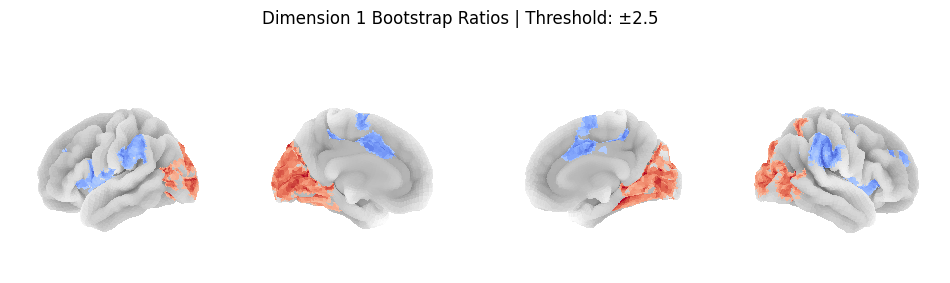

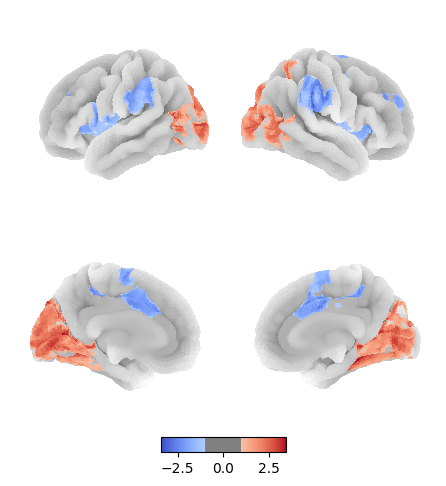

In [ ]:
# Load fsaverage surface
surf = datasets.fetch_surf_fsaverage()

# Load Gordon atlas
gordon_img = nib.load("./gordon_networks_222.nii")
gordon_data = gordon_img.get_fdata()
affine = gordon_img.affine
hdr = gordon_img.header

# Create volume to hold V1 values (initialized to zero)
v1_volume = np.zeros_like(gordon_data)

# Loop through unique atlas values
for atlas_val in merged_df["atlas_value"].dropna().unique():
    # Get all Dimension 1 values for this atlas region
    vals = merged_df.loc[merged_df["atlas_value"] == atlas_val, "Dimension 1"]

    # Filter for bootstrap ratios > 2.5 or < -2.5
    sig_vals = vals[(vals > 2.5) | (vals < -2.5)]

    # If at least one value passes threshold, assign the average to the region
    if not sig_vals.empty:
        mean_val = sig_vals.mean()
        v1_volume[gordon_data == atlas_val] = mean_val

# Convert to NIfTI image
v1_img = nib.Nifti1Image(v1_volume, affine, hdr)

# Define colormap and max value
from matplotlib import cm

cmap = "coolwarm"
vmax = np.abs(merged_df["Dimension 1"]).max()

# Plot 
fig_stat, fig_img = plot_surfaces(
    nifti=v1_img,
    surf=surf,
    cmap=cmap,
    vmax=vmax,
    threshold=1,  # mask out 0s
)

fig_stat.suptitle("Dimension 1 Bootstrap Ratios | Threshold: ±2.5", y=0.9)
plt.show()

## Plot LME

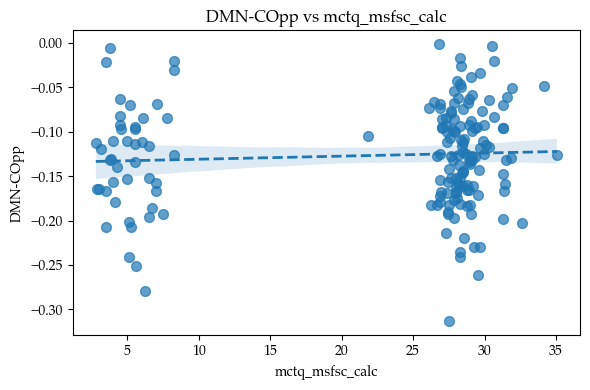

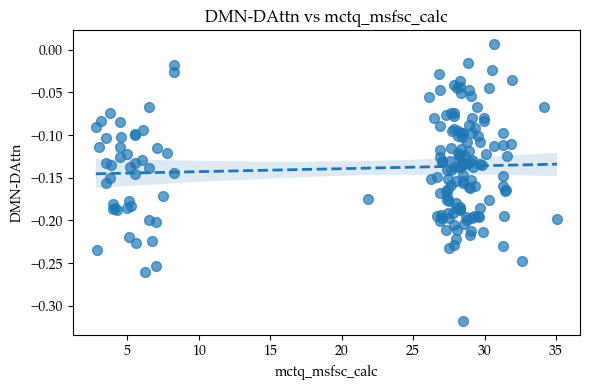

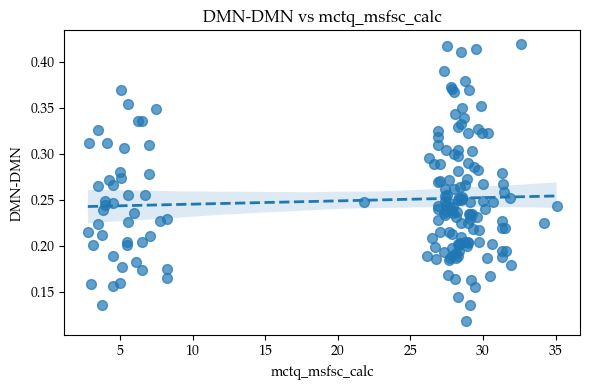

In [ ]:
REG_DIR = "./derivatives/regression"

# Set global font properties
plt.rcParams["font.family"] = "Palatino"  # Change to the desired font
plt.rcParams["font.weight"] = "bold"  # Set all fonts to bold

reg_df = pd.read_csv(join(REG_DIR, "regression.csv"))

rsfc_reg_measures = [
    "rsfmri_c_ngd_cgc_ngd_dt",
    "rsfmri_c_ngd_dt_ngd_dla",
    "rsfmri_c_ngd_dt_ngd_dt",
]

# renamed the abide 2 phenotypes
rsfc_map = {
    "rsfmri_c_ngd_cgc_ngd_dt": "DMN-COpp",
    "rsfmri_c_ngd_dt_ngd_dla": "DMN-DAttn",
    "rsfmri_c_ngd_dt_ngd_dt": "DMN-DMN",
}

# phyhealth_col = "resp_wheeze_yn_y"
phyhealth_col = "mctq_msfsc_calc"

for measure in rsfc_reg_measures:
    pretty = rsfc_map.get(measure, measure)

    plt.figure(figsize=(6, 4))
    sns.regplot(
        x=phyhealth_col,
        y=measure,
        data=reg_df,
        scatter_kws={"alpha": 0.7, "s": 50},
        line_kws={"linewidth": 2, "ls": "--", "clip_on": False},  # <-- important
    )
    plt.xlabel(phyhealth_col, weight="bold")
    plt.ylabel(pretty, weight="bold")
    plt.title(f"{pretty} vs {phyhealth_col}", weight="bold")
    plt.tight_layout()
    plt.show()

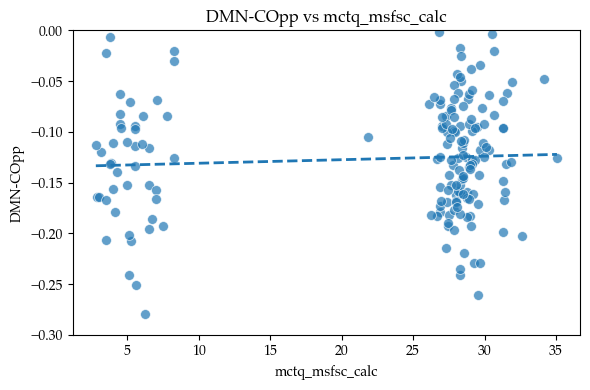

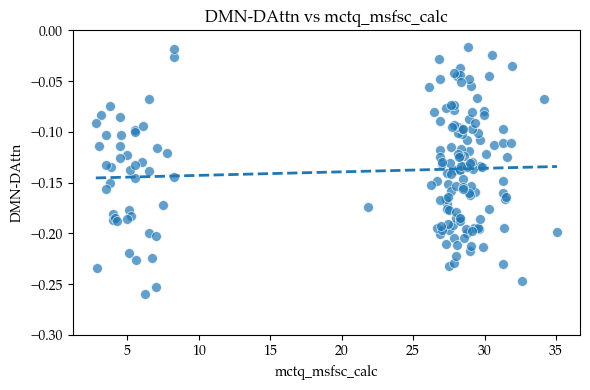

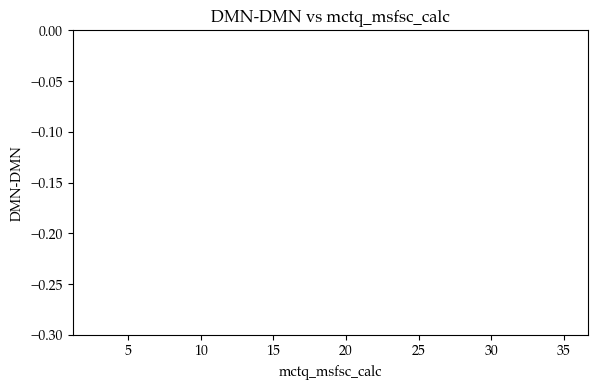

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from scipy.stats import linregress
import numpy as np

REG_DIR = "./derivatives/regression"

plt.rcParams["font.family"] = "Palatino"
plt.rcParams["font.weight"] = "bold"

reg_df = pd.read_csv(join(REG_DIR, "regression.csv"))

rsfc_reg_measures = [
    "rsfmri_c_ngd_cgc_ngd_dt",
    "rsfmri_c_ngd_dt_ngd_dla",
    "rsfmri_c_ngd_dt_ngd_dt",
]

rsfc_map = {
    "rsfmri_c_ngd_cgc_ngd_dt": "DMN-COpp",
    "rsfmri_c_ngd_dt_ngd_dla": "DMN-DAttn",
    "rsfmri_c_ngd_dt_ngd_dt": "DMN-DMN",
}

phyhealth_col = "mctq_msfsc_calc"

for measure in rsfc_reg_measures:
    pretty = rsfc_map.get(measure, measure)

    x = reg_df[phyhealth_col]
    y = reg_df[measure]

    # Fit regression using all data
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = intercept + slope * x_vals

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=x, y=y, alpha=0.7, s=50)
    plt.plot(x_vals, y_vals, "--", linewidth=2)  # Full regression line

    plt.xlabel(phyhealth_col, weight="bold")
    plt.ylabel(pretty, weight="bold")
    plt.title(f"{pretty} vs {phyhealth_col}", weight="bold")

    # Zoom in without refitting or redrawing regression
    plt.tight_layout()
    plt.ylim(-0.30, 0.00)  # Set y-axis (z-coordinate) limits
    plt.show()





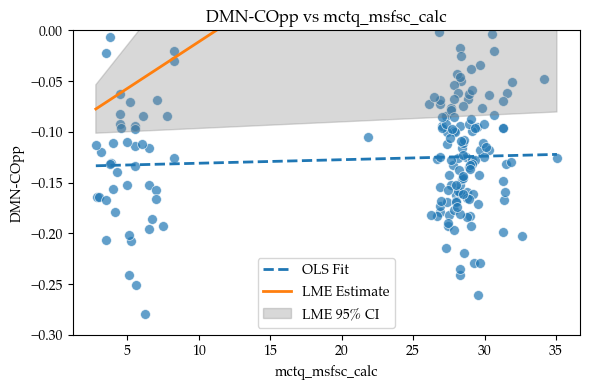

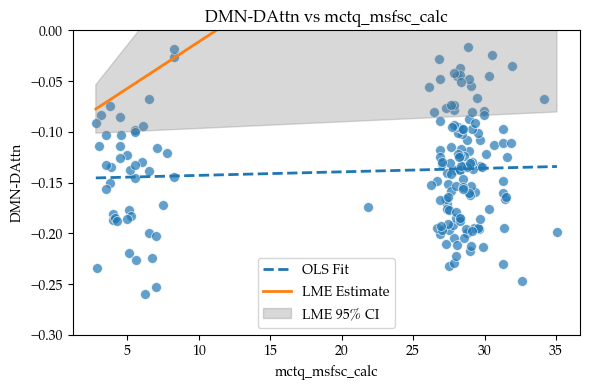

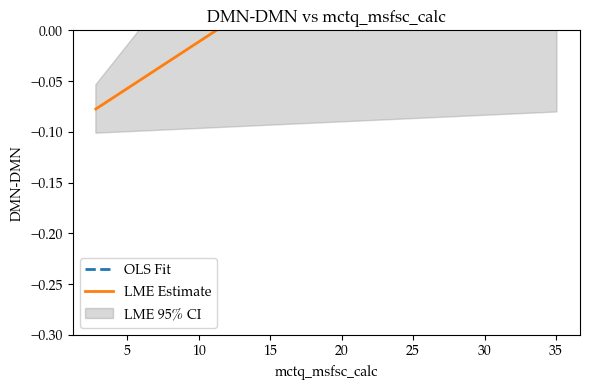

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from scipy.stats import linregress, t
import numpy as np

REG_DIR = "./derivatives/regression"

plt.rcParams["font.family"] = "Palatino"
plt.rcParams["font.weight"] = "bold"

reg_df = pd.read_csv(join(REG_DIR, "regression.csv"))

rsfc_reg_measures = [
    "rsfmri_c_ngd_cgc_ngd_dt",
    "rsfmri_c_ngd_dt_ngd_dla",
    "rsfmri_c_ngd_dt_ngd_dt",
]

rsfc_map = {
    "rsfmri_c_ngd_cgc_ngd_dt": "DMN-COpp",
    "rsfmri_c_ngd_dt_ngd_dla": "DMN-DAttn",
    "rsfmri_c_ngd_dt_ngd_dt": "DMN-DMN",
}

phyhealth_col = "mctq_msfsc_calc"

# From your R LME output
lme_estimate = 0.00919349452795043  # Slope for mctq_msfsc_calc
lme_intercept = -0.103121027119344  # Intercept
lme_se = 0.00432508649601349  # Std. Error
lme_df = 151.05  # Degrees of freedom

for measure in rsfc_reg_measures:
    pretty = rsfc_map.get(measure, measure)

    x = reg_df[phyhealth_col]
    y = reg_df[measure]

    # Fit OLS regression using all data
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals_ols = intercept + slope * x_vals

    # LME model fit
    y_vals_lme = lme_intercept + lme_estimate * x_vals

    # 95% CI for LME slope
    t_crit = t.ppf(0.975, df=lme_df)
    slope_upper = lme_estimate + t_crit * lme_se
    slope_lower = lme_estimate - t_crit * lme_se
    y_upper = lme_intercept + slope_upper * x_vals
    y_lower = lme_intercept + slope_lower * x_vals

    # Plot
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=x, y=y, alpha=0.7, s=50)

    plt.plot(x_vals, y_vals_ols, "--", linewidth=2, label="OLS Fit")
    plt.plot(x_vals, y_vals_lme, "-", linewidth=2, label="LME Estimate")
    plt.fill_between(
        x_vals, y_lower, y_upper, color="gray", alpha=0.3, label="LME 95% CI"
    )

    plt.xlabel(phyhealth_col, weight="bold")
    plt.ylabel(pretty, weight="bold")
    plt.title(f"{pretty} vs {phyhealth_col}", weight="bold")
    plt.ylim(-0.30, 0.00)
    plt.legend()
    plt.tight_layout()
    plt.show()